In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate # type: ignore
from tensorflow.keras.models import Model # type: ignore
from datetime import datetime

In [3]:
movies = pd.read_csv("datasets/movies.csv")
ratings = pd.read_csv("datasets/ratings.csv")
tags = pd.read_csv("datasets/tags.csv")

In [5]:
movies_with_ratings = pd.merge(movies,ratings,on='movieId')
movies_with_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [6]:
movies_with_ratings = movies_with_ratings.sort_values(by=['userId', 'movieId', 'timestamp'], ascending=[True, True, False])
movies_with_ratings = movies_with_ratings.drop_duplicates(subset=['userId', 'movieId'], keep='first')
movies_with_ratings = movies_with_ratings.reset_index(drop=True)

In [29]:
movies_with_ratings['release_year'] = movies_with_ratings['title'].str.extract(r'\((\d{4})\)')
movies_with_ratings['release_year'] = pd.to_numeric(movies_with_ratings['release_year'], errors='coerce')


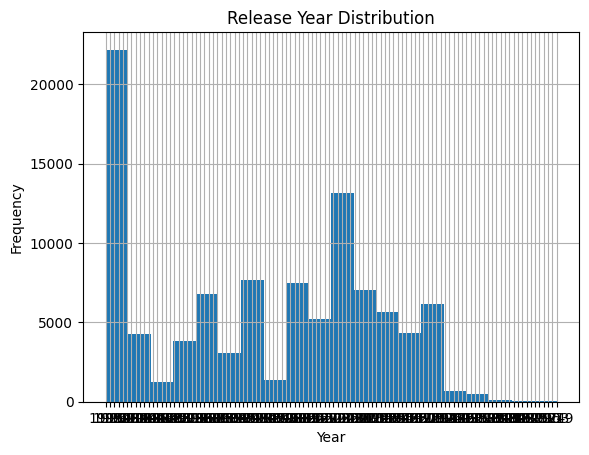

In [ ]:
import matplotlib.pyplot as plt
movies_with_ratings['release_year'].hist(bins=20)
plt.title('Release Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


In [ ]:
median_year = movies_with_ratings['release_year'].median()
movies_with_ratings['release_year'] = movies_with_ratings['release_year'].fillna(median_year)

In [8]:
def compute_time_decay(timestamp, current_time, lambda_decay=0.001):
    time_difference = (current_time - timestamp) / (60 * 60 * 24) 
    decay_weight = np.exp(-lambda_decay * time_difference)
    return decay_weight

In [32]:
def compute_year_decay(release_year, latest_year, lambda_year=0.001):
    year_difference = latest_year - release_year
    year_decay_weight = np.exp(-lambda_year * year_difference)
    return year_decay_weight


In [36]:
current_time = movies_with_ratings['timestamp'].max()
movies_with_ratings['time_decay_weight'] = movies_with_ratings['timestamp'].apply(
    lambda x: compute_time_decay(x, current_time)
)

In [37]:
current_year = movies_with_ratings['release_year'].max()
movies_with_ratings['year_decay_weight'] = movies_with_ratings['release_year'].apply(
    lambda x: compute_time_decay(x, current_year)
)

In [38]:
movies_with_ratings['combined_decay'] = (
    movies_with_ratings['time_decay_weight'] * movies_with_ratings['year_decay_weight']
)


In [39]:
movies_with_ratings['userId'] -= 1
movies_with_ratings['movieId'] -= 1

train, test = train_test_split(movies_with_ratings, test_size=0.2, random_state=42)

In [40]:
train['userId'], user_index = pd.factorize(train['userId'])
train['movieId'], movie_index = pd.factorize(train['movieId'])
test['userId'] = test['userId'].map(lambda x: user_index.get_loc(x) if x in user_index else -1)
test['movieId'] = test['movieId'].map(lambda x: movie_index.get_loc(x) if x in movie_index else -1)
test = test[(test['userId'] != -1) & (test['movieId'] != -1)]

In [41]:
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(input_dim=movies_with_ratings['userId'].nunique(), output_dim=50, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=movies_with_ratings['movieId'].nunique(), output_dim=50, name='item_embedding')(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

concat = Concatenate()([user_vector, item_vector])
dense_1 = Dense(128, activation='relu')(concat)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(1, activation='sigmoid')(dense_2)


In [42]:
model = Model([user_input, item_input], output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     30,500 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 50)     │    486,200 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     12,928 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 537,949 (2.05 MB)

 Trainable params: 537,949 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
train_user = train['userId'].values
train_item = train['movieId'].values
train_rating = (train['rating'].values / 5.0)  * train['combined_decay'].values 

test_user = test['userId'].values
test_item = test['movieId'].values
test_rating = (test['rating'].values / 5.0) * test['combined_decay'].values

history = model.fit(
    [train_user, train_item], train_rating,
    validation_data=([test_user, test_item], test_rating),
    epochs=10, batch_size=256, verbose=1
)


Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 3.6245e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0054
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 3.1908e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0054
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 3.1486e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0053
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 3.2498e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0053
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 2.9196e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0053
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 2.7556e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0053
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 2.5415e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0053
Epoch 8/10
316/316 ━

In [47]:
def recommend_items(user_id, model, n=5):
    item_ids = np.arange(movies_with_ratings['movieId'].nunique())
    user_array = np.full(len(item_ids), user_id)
    predictions = model.predict([user_array, item_ids]).flatten()
    top_n_items = predictions.argsort()[-n:][::-1]
    recommended_movie_ids = movie_index[top_n_items]
    recommended_movies = movies_with_ratings[movies_with_ratings["movieId"].isin(recommended_movie_ids)]
    recommended_titles = recommended_movies["title"].tolist()
    return recommended_titles

print("Recommended items:", recommend_items(5, model, n=5))

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Recommended items: ['The Revenant (2015)', 'The Revenant (2015)', 'Blade Runner 2049 (2017)', 'The Revenant (2015)', 'The Revenant (2015)', 'The Revenant (2015)', 'The Revenant (2015)', 'Blade Runner 2049 (2017)', 'The Revenant (2015)', 'Blade Runner 2049 (2017)', 'The Revenant (2015)', 'Blade Runner 2049 (2017)', 'Love & Mercy (2014)', 'The Revenant (2015)', 'The Revenant (2015)', 'The Revenant (2015)', 'Hunt for the Wilderpeople (2016)', 'Blade Runner 2049 (2017)', 'The Revenant (2015)', 'Blade Runner 2049 (2017)', 'Hunt for the Wilderpeople (2016)', 'The Revenant (2015)', 'Blade Runner 2049 (2017)', 'The Revenant (2015)', 'Hunt for the Wilderpeople (2016)', 'Blade Runner 2049 (2017)', 'The Revenant (2015)', 'The Revenant (2015)', 'The Revenant (2015)', 'The Revenant (2015)', 'Love & Mercy (2014)', 'Blade Runner 2049 (2017)', 'The Revenant (2015)', 'The Revenant (2015)', 'Blade Runner 2049 (2017)', 'The Revenant (2015)', 'Blade Runner 2049 (20